In [1]:
import keras

Using TensorFlow backend.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio as im
import os
import time

%matplotlib inline


In [4]:
import matplotlib.image as mpimg
import seaborn as sns
import cv2
sns.set(style='white', context='notebook', palette='deep')

In [5]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, roc_curve, classification_report, recall_score, precision_score, f1_score
import itertools

In [7]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [8]:
# importante:
"""
      ('SeriesNumber', 3000534),
      ('InstanceNumber', 2),
   
   SeriesNumber = index da planilha para referencia, coluna scan
   InstanceNumber é o slice
   
   Cada slice é 1 cm (confirmar)
   scan 3000548 verificar
   
   x loc da esquerda pra direita e y loc de cima pra baixo
"""
print('')

In [8]:
cases = pd.read_csv(r'C:\Users\rodri\2 Mestrado\Programa - medicina\87/lista.csv')
cases.head(10)

,case,scan,roi,volume,diameter,x lox,y loc,slice
0,1,3000566,1,645975,23107,317,367,43
1,2,3000522,1,666344,23347,345,361,77
2,3,3000611,1,40879,9208,308,198,57
3,3,3000611,2,116582,13058,221,219,56
4,3,3000611,3,498964,21201,367,350,65
5,3,3000611,4,427635,20138,369,347,74
6,4,3000534,1,5832,4811,142,323,165
7,5,3000548,1,11576,6047,313,407,53
8,5,3000548,2,7607,5257,127,398,56
9,5,3000548,3,6945,5100,407,377,45


In [9]:
23107/1000 #milimetros

23.107

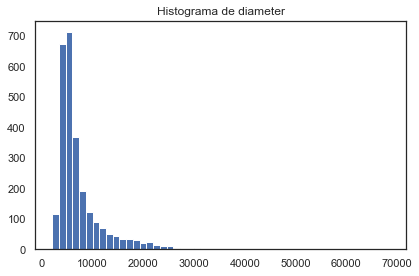

In [10]:
plt.hist(cases['diameter'], bins=50)
plt.title('Histograma de diameter')
plt.tight_layout()

In [11]:
cases['slice'].value_counts().head()

64    31
78    29
51    29
60    27
49    27
Name: slice, dtype: int64

Example image has shape:  (512, 512)


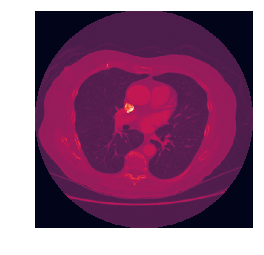

In [13]:
# load an image and explore
example_image = im.imread(r'C:\Users\rodri\2 Mestrado\Teste implementação - antigos\LIDC-IDRI-0001\01-01-2000-30178\3000566-03192/000083.dcm')

# show image
plt.imshow(example_image)
plt.axis('off')

# print shape
print('Example image has shape: ', example_image.shape)

In [14]:
loaded_images = pd.DataFrame(columns=['scan', 'slice'])
list_images = []
loaded_images

,scan,slice


In [19]:
def leitura_update(path):

    global loaded_images
    global list_images

    start = time.time()

    for file_name in os.listdir(url_base):
        
        start = time.time()
        
        for file2 in os.listdir(url_base+'/'+file_name):
            for file3 in os.listdir(url_base+'/'+file_name+'/'+file2):
                for file4 in os.listdir(url_base+'/'+file_name+'/'+file2+'/'+file3):

                    if file4.endswith('.dcm'):
                        img = im.imread(os.path.join(url_base, file_name, file2, file3, file4)).astype(np.float64)
                        img_dic = img.meta
                        scan = img_dic['SeriesNumber']
                        slice_n = img_dic['InstanceNumber']
                        loaded_images.loc[len(loaded_images)] = [scan, slice_n]
                        img = cv2.resize(img, (100, 100)) # redução dimensional
                        list_images.append(img)
    
        end = time.time()-start

        print('Levou', round(end,2), 'segundos para executar na pasta', file_name)
    


In [22]:
# para carregar
import pickle

with open('87/mylist_15_10_2019', 'rb') as f:
    list_images = pickle.load(f)


In [23]:
len(list_images)

9066

In [26]:
# Adicionando novas imagens na lista antiga

url_base = r'C:\Users\rodri\2 Mestrado\Programa - medicina\adicionando fotos'

leitura_update(url_base)

Levou 0.95 segundos para executar na pasta LIDC-IDRI-0061
Levou 0.58 segundos para executar na pasta LIDC-IDRI-0062
Levou 0.64 segundos para executar na pasta LIDC-IDRI-0063
Levou 0.66 segundos para executar na pasta LIDC-IDRI-0064
Levou 1.16 segundos para executar na pasta LIDC-IDRI-0065
Levou 3.81 segundos para executar na pasta LIDC-IDRI-0066
Levou 1.21 segundos para executar na pasta LIDC-IDRI-0067
Levou 1.3 segundos para executar na pasta LIDC-IDRI-0068
Levou 0.68 segundos para executar na pasta LIDC-IDRI-0069
Levou 0.66 segundos para executar na pasta LIDC-IDRI-0070


In [27]:
len(list_images)

11316

In [28]:
normalized_list = []
for i in list_images:
    normalized_list.append(normalize(i))

In [29]:
X = np.array(normalized_list)

In [30]:
X.shape

(11316, 100, 100)

In [31]:
X = X.reshape(-1,100,100,1)
X.shape

(11316, 100, 100, 1)

In [32]:
loaded_images.head()

,scan,slice
0,3000560,80
1,3000560,52
2,3000560,42
3,3000560,59
4,3000560,28


In [33]:
to_add = cases[['scan', 'slice']].copy()
to_add['has_tumor'] = 1
to_add.head()

,scan,slice,has_tumor
0,3000566,43,1
1,3000522,77,1
2,3000611,57,1
3,3000611,56,1
4,3000611,65,1


In [34]:
loaded_images_grouped = pd.merge(loaded_images,
                 to_add,
                 on=['scan','slice'],
                 how = 'left')
loaded_images_grouped.fillna(0, inplace=True)
loaded_images_grouped.head()

,scan,slice,has_tumor
0,3000560,80,0.0
1,3000560,52,0.0
2,3000560,42,0.0
3,3000560,59,0.0
4,3000560,28,0.0


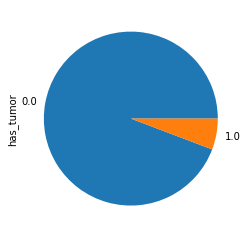

In [98]:
loaded_images_grouped['has_tumor'].value_counts().plot(kind='pie');

In [39]:
loaded_images_grouped['ID'] = np.arange(len(loaded_images_grouped))

In [40]:
tumor = loaded_images_grouped[loaded_images_grouped.has_tumor==1]
not_tumor = loaded_images_grouped[loaded_images_grouped.has_tumor==0]

In [41]:
from sklearn.utils import resample
tumor_upsampled = resample(tumor,
                          replace=True, # sample with replacement
                          n_samples=750, # match number in majority class
                          random_state=12) # reproducible results

not_tumor_downsampled = resample(not_tumor,
                          replace=False, # sample with replacement
                          n_samples=750, # match number in majority class
                          random_state=12) # reproducible results

In [42]:
resampled = pd.concat([tumor_upsampled, not_tumor_downsampled])

In [43]:
X_resampled = []
for row in resampled.ID:
    X_resampled.append(X[row])
X_resampled = np.array(X_resampled)
X_resampled.shape

(1500, 100, 100, 1)

In [106]:
y = resampled['has_tumor'].values
y = np.array(y)
y = to_categorical(y, num_classes = 2)    # tem tumor = [0,1], sem tumor = [1,0]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y, test_size = 0.3, random_state=12, stratify=y)

print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')
print(y_train.shape, 'respostas do treino')
print(y_test.shape, 'respostas do teste')

(1050, 100, 100, 1) train samples
(450, 100, 100, 1) test samples
(1050, 2) respostas do treino
(450, 2) respostas do teste


In [46]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (100,100,1)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation = "relu"))

model.add(Dropout(0.25))

model.add(Dense(2, activation = "softmax"))   #NUMERO DE OUTPUTS

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)    

In [47]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [48]:
# Compile the model
model.compile(optimizer = optimizer
              , loss = "categorical_crossentropy"
              , metrics=["accuracy"])

In [49]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=0, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [50]:
epochs = 45
batch_size = 40

In [51]:
# data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=3,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.05, # Randomly zoom image 
        width_shift_range=False,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=False,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [52]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_test,y_test),
                              verbose = 0, 
                              steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.


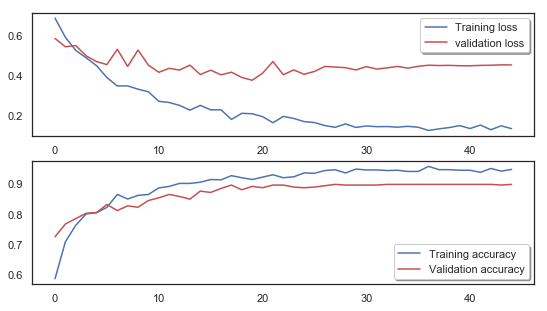

In [53]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(9, 5))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [54]:
predictions = model.predict_classes(X_test)

In [55]:
print('Acuracidade do modelo: ',round(accuracy_score(predictions,np.argmax(y_test, axis = 1))*100,2), '%')
print('Demais Indicadores: \n')
print('   recall_score: ',round(recall_score(predictions,np.argmax(y_test, axis = 1)),2))
print('   precision_score: ',round(precision_score(predictions,np.argmax(y_test, axis = 1)),2))
print('   f1_score: ',round(f1_score(predictions,np.argmax(y_test, axis = 1)),2))
print('   roc: ',round(roc_auc_score(predictions,np.argmax(y_test, axis = 1)),2))

Acuracidade do modelo:  89.78 %
Demais Indicadores: 

   recall_score:  0.85
   precision_score:  0.97
   f1_score:  0.9
   roc:  0.91


In [56]:
print(classification_report(predictions,np.argmax(y_test, axis = 1)))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       193
           1       0.97      0.85      0.90       257

   micro avg       0.90      0.90      0.90       450
   macro avg       0.90      0.91      0.90       450
weighted avg       0.91      0.90      0.90       450



In [57]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix'):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    cmap = plt.get_cmap('Blues')
    plt.rcParams.update(plt.rcParamsDefault)
    %matplotlib inline
    
    #plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

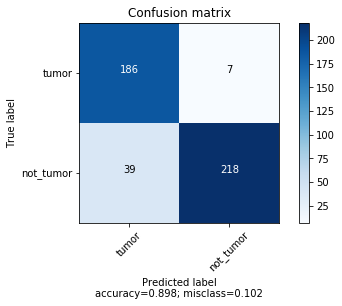

In [60]:
plot_confusion_matrix(confusion_matrix(predictions,np.argmax(y_test, axis = 1)),target_names=['tumor','not_tumor'])

AUC: 0.935


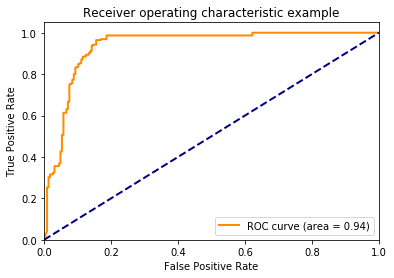

In [62]:
# predict probabilities
probs = model.predict(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(np.argmax(y_test, axis = 1), probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(np.argmax(y_test, axis = 1), probs)
# plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [85]:
# Salvando os pesos do modelo com bom desempenho

model.save_weights('my_model_weights2.h5')

In [86]:
# Salvando o modelo em si

model.save('my_model2')

In [97]:
# para carregar

'''
model.load_weights('my_model_weights.h5')
from keras.models import load_model
new_model = load_model('my_model')
''';

In [63]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (predictions - np.argmax(y_test, axis=1) != 0)
print("De um total de",len(predictions), "errou", sum(errors), "vezes")

De um total de 450 errou 46 vezes


In [64]:
# Dados de entrada dos previstos errados
X_test[errors].shape

(46, 100, 100, 1)

In [65]:
# Ajustando dimensões para uma imagem
X_test[errors][37].reshape(100,100).shape

(100, 100)

In [66]:
# Acessando os originais
np.argmax(y_test[errors], axis=1).shape

(46,)

In [67]:
# Acessando a resposta original de alguma previsão
np.argmax(y_test[errors], axis=1)[1]

0

Imagens que o sistema previu errado, com sua resposta original 



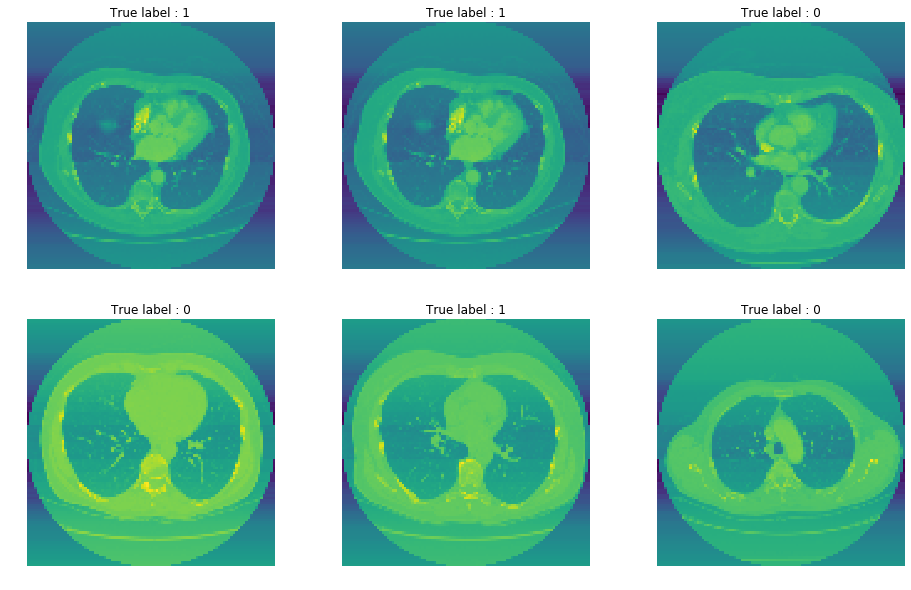

In [84]:
print('Imagens que o sistema previu errado, com sua resposta original \n')
fig, ax = plt.subplots(2,3, figsize=(16, 10), sharex=True,sharey=True)
ax[0,0].imshow(X_test[errors][37].reshape(100,100))
ax[0,0].set_title("True label : {}".format(np.argmax(y_test[errors], axis=1)[37]))

ax[0,1].imshow(X_test[errors][2].reshape(100,100))
ax[0,1].set_title("True label : {}".format(np.argmax(y_test[errors], axis=1)[2]))

ax[0,2].imshow(X_test[errors][27].reshape(100,100))
ax[0,2].set_title("True label : {}".format(np.argmax(y_test[errors], axis=1)[27]))

ax[1,1].imshow(X_test[errors][31].reshape(100,100))
ax[1,1].set_title("True label : {}".format(np.argmax(y_test[errors], axis=1)[31]))
               
ax[1,0].imshow(X_test[errors][34].reshape(100,100))
ax[1,0].set_title("True label : {}".format(np.argmax(y_test[errors], axis=1)[34]))

ax[1,2].imshow(X_test[errors][38].reshape(100,100))
ax[1,2].set_title("True label : {}".format(np.argmax(y_test[errors], axis=1)[38]))

ax[0,0].axis('off')
ax[1,0].axis('off')
ax[1,2].axis('off')
ax[0,1].axis('off')
ax[1,1].axis('off')
ax[0,2].axis('off')


plt.show()

In [89]:
# Display some correct results 

acertos = (predictions - np.argmax(y_test, axis=1) == 0)
print("De um total de",len(predictions), "acertou", sum(acertos), "vezes")

De um total de 450 acertou 404 vezes


Imagens que o sistema previu certo, com sua resposta original 



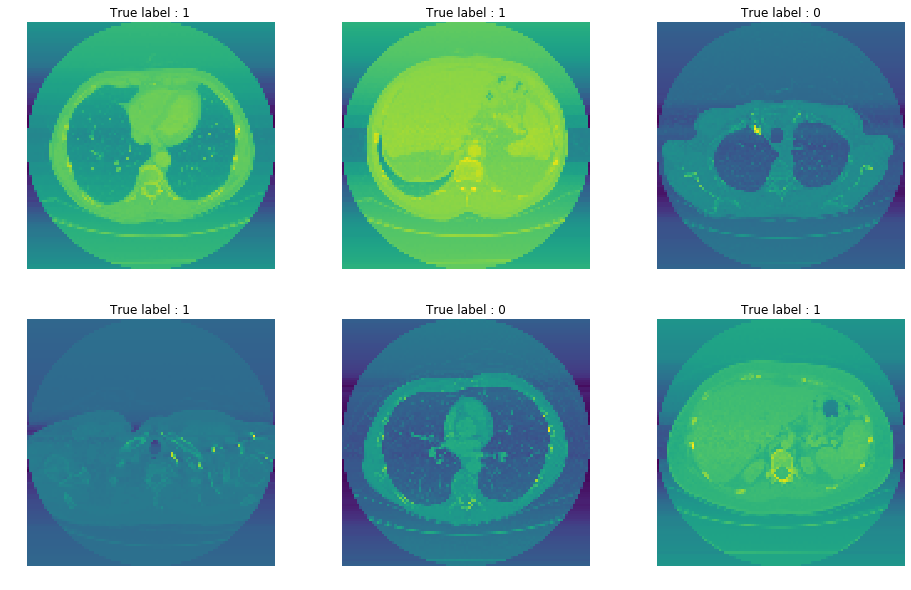

In [91]:
print('Imagens que o sistema previu certo, com sua resposta original \n')
fig, ax = plt.subplots(2,3, figsize=(16, 10), sharex=True,sharey=True)
ax[0,0].imshow(X_test[acertos][40].reshape(100,100))
ax[0,0].set_title("True label : {}".format(np.argmax(y_test[acertos], axis=1)[40]))

ax[0,1].imshow(X_test[acertos][50].reshape(100,100))
ax[0,1].set_title("True label : {}".format(np.argmax(y_test[acertos], axis=1)[50]))

ax[0,2].imshow(X_test[acertos][60].reshape(100,100))
ax[0,2].set_title("True label : {}".format(np.argmax(y_test[acertos], axis=1)[60]))

ax[1,1].imshow(X_test[acertos][70].reshape(100,100))
ax[1,1].set_title("True label : {}".format(np.argmax(y_test[acertos], axis=1)[70]))
               
ax[1,0].imshow(X_test[acertos][80].reshape(100,100))
ax[1,0].set_title("True label : {}".format(np.argmax(y_test[acertos], axis=1)[80]))

ax[1,2].imshow(X_test[acertos][90].reshape(100,100))
ax[1,2].set_title("True label : {}".format(np.argmax(y_test[acertos], axis=1)[90]))

ax[0,0].axis('off')
ax[1,0].axis('off')
ax[1,2].axis('off')
ax[0,1].axis('off')
ax[1,1].axis('off')
ax[0,2].axis('off')


plt.show()